# Yelp Dataset

## Preprocessing

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

try:
  train_df = pd.read_csv('/content/drive/MyDrive/yelp_dataset/train.csv', names=['label', 'text'], header=None)
  test_df = pd.read_csv('/content/drive/MyDrive/yelp_dataset/test.csv', names=['label', 'text'], header=None)
  print("Files loaded successfully.")
except FileNotFoundError:
  print("Error: One or both files not found in the specified location. Check the file paths.")
except pd.errors.ParserError:
  print("Error: Could not parse the CSV files. Check their format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files loaded successfully.


In [6]:
train_subset = pd.concat([
    train_df[train_df.label == 1].sample(10000, random_state=42),  # Negative class
    train_df[train_df.label == 2].sample(10000, random_state=42)   # Positive class
])


In [7]:
test_subset = pd.concat([
    test_df[test_df.label == 1].sample(1000, random_state=42),
    test_df[test_df.label == 2].sample(1000, random_state=42)
])

In [8]:
train_subset = train_subset.sample(frac=1, random_state=42).reset_index(drop=True)
test_subset = test_subset.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
train_subset['label'] = train_subset['label'].replace({1:0, 2:1})
test_subset['label'] = test_subset['label'].replace({1:0, 2:1})

In [10]:
nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data Prepprocessing steps:


1.   Replacing special characters
2.   Remove punctuation and numbers
3.   Case folding
4.   Tokenization
5.   Stop word removal
6.   Lemmatization



In [11]:
def preprocess(text):
    text = text.replace('\\"', ' ').replace('\\n', ' ')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'very'}
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

In [12]:
# Apply preprocessing
train_subset['processed'] = train_subset['text'].apply(preprocess)
test_subset['processed'] = test_subset['text'].apply(preprocess)

## Word2vec and Tokenization

In [2]:
#!pip install gensim

In [1]:
from gensim.models import Word2Vec

In [13]:
w2v_model = Word2Vec(
    sentences=train_subset['processed'].tolist(),
    vector_size=300,
    window=5,
    min_count=5,
    workers=2,
    epochs=5
)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_subset['processed'])

In [16]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_subset['processed']), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_subset['processed']), maxlen=100)

In [17]:

import numpy as np

In [18]:
embedding_matrix = np.zeros((20000, 300))
for word, i in tokenizer.word_index.items():
    if i < 20000 and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

## Model Training and Evaluation (LSTM and MLP)

In [19]:
from tensorflow.keras.layers import Flatten

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

In [21]:
import time
from tabulate import tabulate

In [22]:
def train_with_progress(model, X_train, y_train, X_test, y_test, batch_size, epochs=5, model_name=""):
    print(f"\n{'='*40}")
    print(f"Training {model_name} (Batch Size: {batch_size})")
    print(f"{'='*40}")

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1
    )

    print(f"\n{model_name} (Batch {batch_size}) Epoch Results:")
    results = []
    for epoch in range(epochs):
        results.append([
            epoch+1,
            history.history['accuracy'][epoch],
            history.history['val_accuracy'][epoch],
            history.history['loss'][epoch],
            history.history['val_loss'][epoch]
        ])

    print(tabulate(results,
                 headers=["Epoch", "Train Acc", "Val Acc", "Train Loss", "Val Loss"],
                 floatfmt=".4f"))

    return history

In [ ]:
# MLP model

mlp_results = []
for batch_size in [32, 64, 128]:
    model_mlp = Sequential([
    Embedding(20000, 300, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
    model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = train_with_progress(
        model_mlp, X_train, train_subset['label'],
        X_test, test_subset['label'],
        batch_size=batch_size,
        model_name="MLP"
    )
    print(f"Training completed in {time.time()-start_time:.2f}s")

    mlp_results.append({
        'batch_size': batch_size,
        'model': model_mlp,
        'history': history,
        'final_val_acc': history.history['val_accuracy'][-1]
    })


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training MLP (Batch Size: 32)
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7922 - loss: 0.4389 - val_accuracy: 0.8410 - val_loss: 0.3665
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8972 - loss: 0.2438 - val_accuracy: 0.8370 - val_loss: 0.3867
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9327 - loss: 0.1694 - val_accuracy: 0.8340 - val_loss: 0.4632
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9588 - loss: 0.1049 - val_accuracy: 0.8240 - val_loss: 0.5582
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9791 - loss: 0.0591 - val_accuracy: 0.8370 - val_loss: 0.6748

MLP (Batch 32) Epoch Results:
  Epoch    Train Acc    Val Acc    Train Loss    Val Loss
-------  -----------  ---------  ------------  ----------
      1       0.8246     0.8410        0.3855      0.3665
      2       0.8874     0.8370        0.2613      0.3867
      3       0.9260     0.8340        0.1813      0.4632
   

In [ ]:
# LSTM model

lstm_results = []
for batch_size in [32, 64, 128]:
    model_lstm = Sequential([
    Embedding(20000, 300, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(64, dropout=0.2),
    Dense(1, activation='sigmoid')
])
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = train_with_progress(
        model_lstm, X_train, train_subset['label'],
        X_test, test_subset['label'],
        batch_size=batch_size,
        model_name="LSTM"
    )
    print(f"Training completed in {time.time()-start_time:.2f}s")

    lstm_results.append({
        'batch_size': batch_size,
        'model': model_lstm,
        'history': history,
        'final_val_acc': history.history['val_accuracy'][-1]
    })


Training LSTM (Batch Size: 32)
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 101ms/step - accuracy: 0.8157 - loss: 0.4005 - val_accuracy: 0.8715 - val_loss: 0.2923
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8838 - loss: 0.2787 - val_accuracy: 0.8900 - val_loss: 0.2686
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.9024 - loss: 0.2369 - val_accuracy: 0.9090 - val_loss: 0.2354
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 103ms/step - accuracy: 0.9173 - loss: 0.2048 - val_accuracy: 0.9030 - val_loss: 0.2330
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - accuracy: 0.9223 - loss: 0.1939 - val_accuracy: 0.9115 - val_loss: 0.2219

LSTM (Batch 32) Epoch Results:
  Epoch    Train Acc    Val Acc    Train Loss    Val Loss
-------  -----------  ---------  ------------  ----------
      1       0.8534     0.8715        0.3380      0.2923
      2       0.8922     0.8900        0.2616      0.2686
      3       0.9047     0.9090        0.2315      0.2

In [ ]:
print("\nMLP Final Comparison:")
print(tabulate([
    [32, mlp_results[0]['final_val_acc']],
    [64, mlp_results[1]['final_val_acc']],
    [128, mlp_results[2]['final_val_acc']]
], headers=["Batch Size", "Val Accuracy"], floatfmt=".4f"))


MLP Final Comparison:
  Batch Size    Val Accuracy
------------  --------------
          32          0.8370
          64          0.8315
         128          0.8305


In [ ]:
print("\nLSTM Final Comparison:")
print(tabulate([
    [32, lstm_results[0]['final_val_acc']],
    [64, lstm_results[1]['final_val_acc']],
    [128, lstm_results[2]['final_val_acc']]
], headers=["Batch Size", "Val Accuracy"], floatfmt=".4f"))


LSTM Final Comparison:
  Batch Size    Val Accuracy
------------  --------------
          32          0.9115
          64          0.9085
         128          0.9080


In [23]:
import matplotlib.pyplot as plt

In [24]:
def plot_model_progress(history, model_name, batch_size):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'b-', label='Train')
    plt.plot(history.history['val_accuracy'], 'r--', label='Validation')
    plt.title(f'{model_name} (Batch {batch_size})\nAccuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0.4, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'b-', label='Train')
    plt.plot(history.history['val_loss'], 'r--', label='Validation')
    plt.title(f'{model_name} (Batch {batch_size})\nLoss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [25]:
def plot_learning_curves(history, model_name, batch_size):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train')
    plt.plot(epochs, val_acc, label='Validation')
    plt.title(f'{model_name} (Batch {batch_size}) - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train')
    plt.plot(epochs, val_loss, label='Validation')
    plt.title(f'{model_name} (Batch {batch_size}) - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


MLP Training Progress:


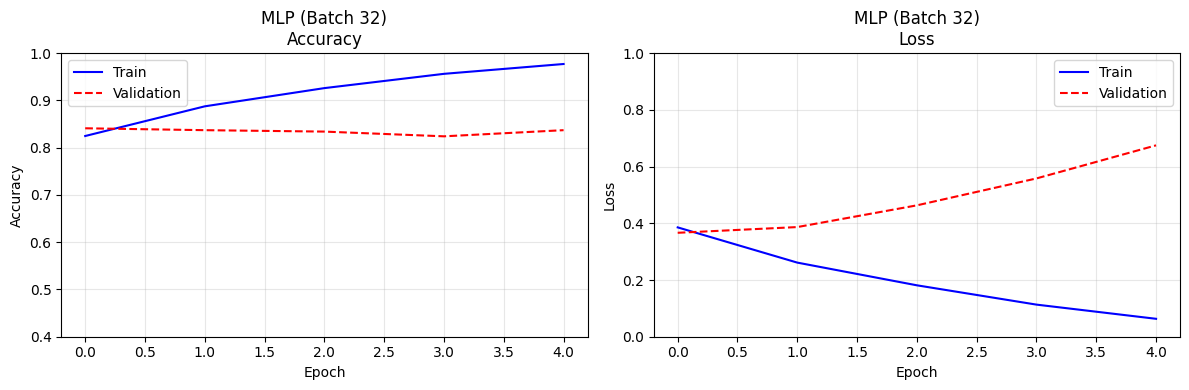

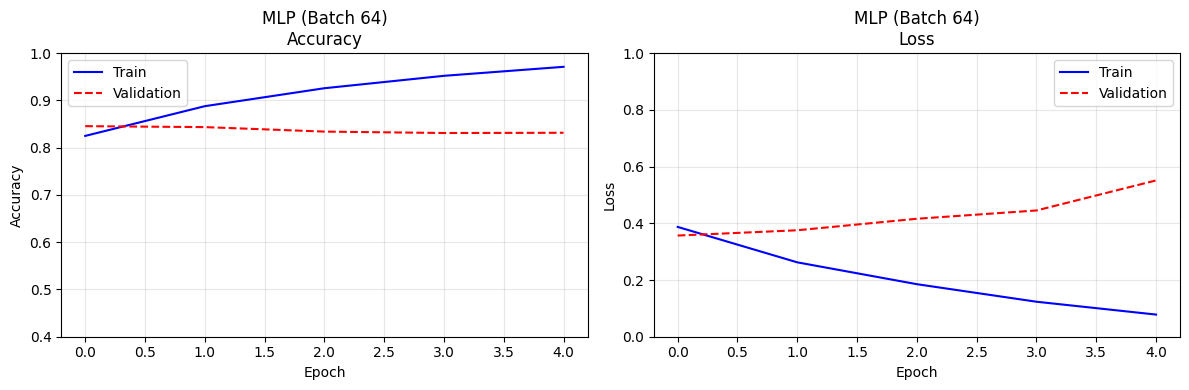

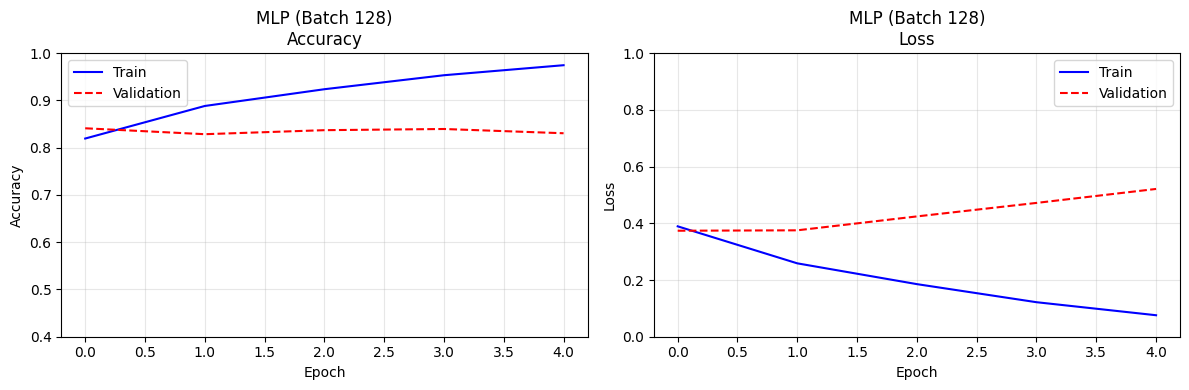

In [ ]:
print("MLP Training Progress:")
for result in mlp_results:
    plot_model_progress(
        result['history'],
        model_name="MLP",
        batch_size=result['batch_size']
    )


LSTM Training Progress:


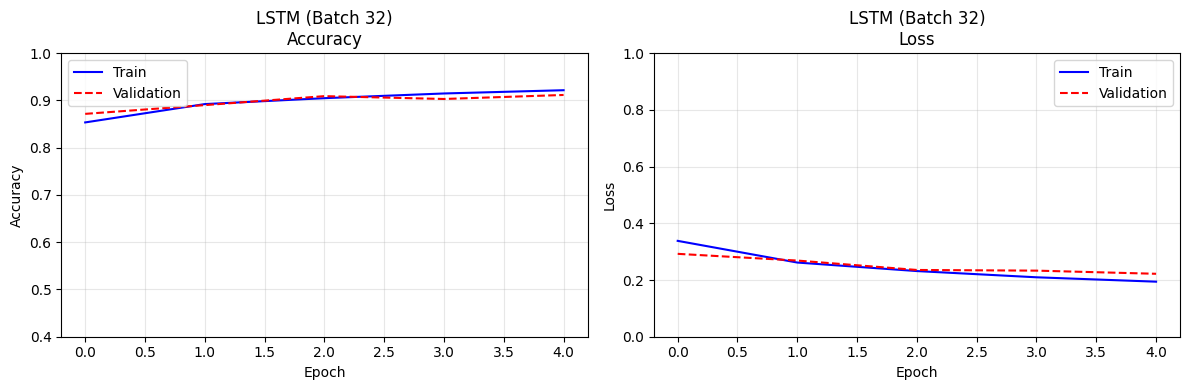

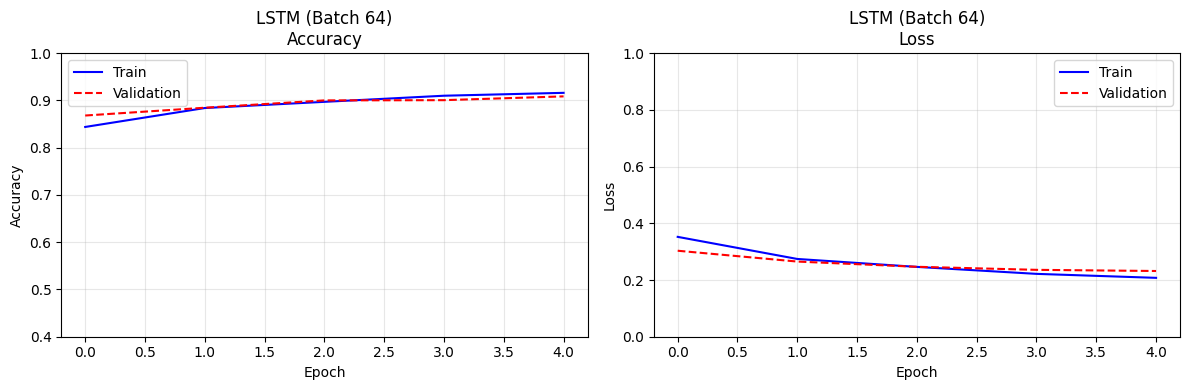

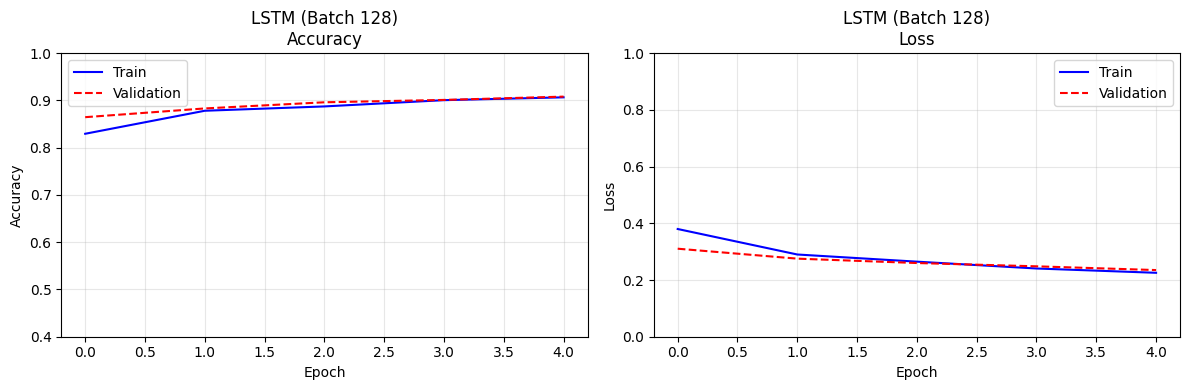

In [ ]:
print("\nLSTM Training Progress:")
for result in lstm_results:
    plot_model_progress(
        result['history'],
        model_name="LSTM",
        batch_size=result['batch_size']
    )


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [27]:
def plot_confusion_matrix(y_true, y_pred, model_name, batch_size):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} (Batch {batch_size})\nConfusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


MLP Confusion Matrices:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


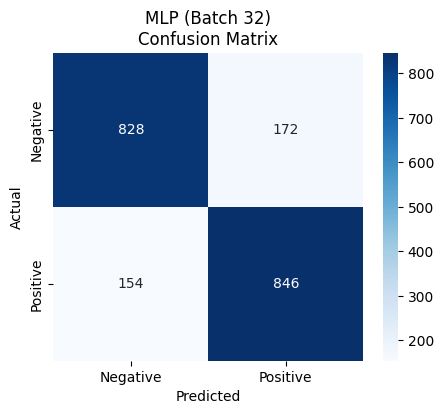


MLP Batch 32 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  828 |                  172 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  154 |                  846 |
+-----------------+----------------------+----------------------+
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


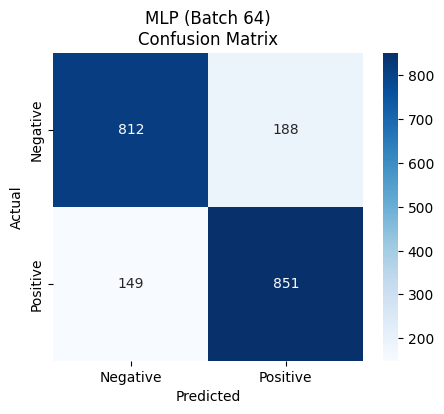


MLP Batch 64 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  812 |                  188 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  149 |                  851 |
+-----------------+----------------------+----------------------+
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


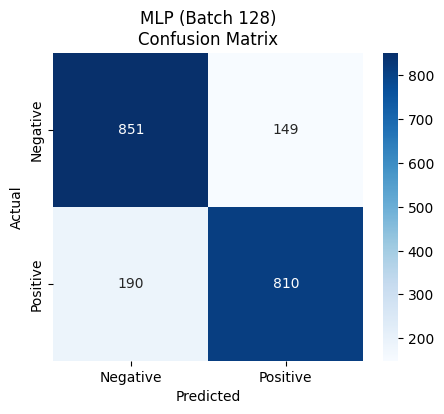


MLP Batch 128 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  851 |                  149 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  190 |                  810 |
+-----------------+----------------------+----------------------+


In [ ]:
print("\nMLP Confusion Matrices:")
for result in mlp_results:
    y_pred = (result['model'].predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(test_subset['label'], y_pred)
    plot_confusion_matrix(test_subset['label'], y_pred,
                         "MLP", result['batch_size'])

    print(f"\nMLP Batch {result['batch_size']} Confusion Matrix:")
    print(tabulate([[cm[0,0], cm[0,1]], [cm[1,0], cm[1,1]]],
                  headers=['Predicted Negative', 'Predicted Positive'],
                  showindex=['Actual Negative', 'Actual Positive'],
                  tablefmt='grid'))


LSTM Confusion Matrices:
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step


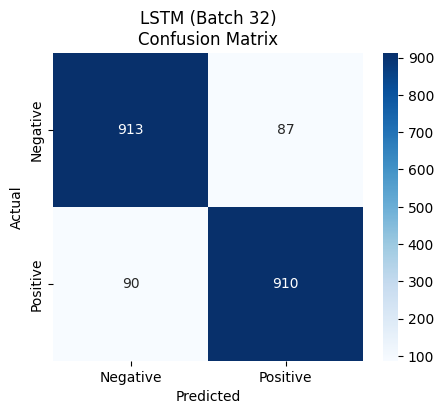


LSTM Batch 32 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  913 |                   87 |
+-----------------+----------------------+----------------------+
| Actual Positive |                   90 |                  910 |
+-----------------+----------------------+----------------------+
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


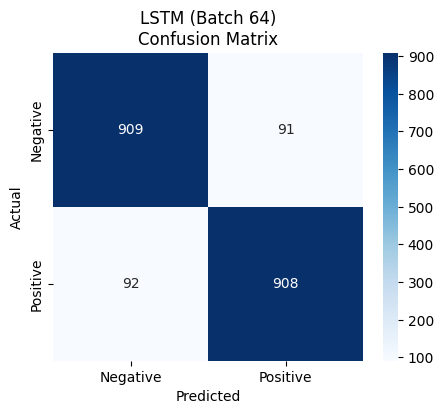


LSTM Batch 64 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  909 |                   91 |
+-----------------+----------------------+----------------------+
| Actual Positive |                   92 |                  908 |
+-----------------+----------------------+----------------------+
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


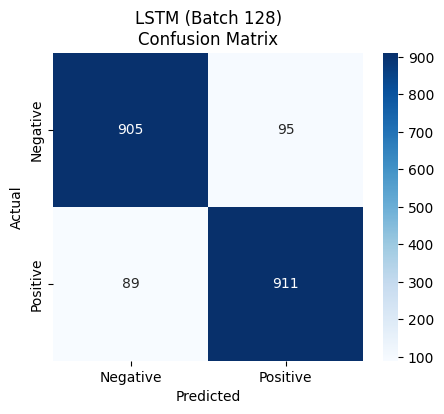


LSTM Batch 128 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  905 |                   95 |
+-----------------+----------------------+----------------------+
| Actual Positive |                   89 |                  911 |
+-----------------+----------------------+----------------------+


In [ ]:
print("\nLSTM Confusion Matrices:")
for result in lstm_results:
    y_pred = (result['model'].predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(test_subset['label'], y_pred)
    plot_confusion_matrix(test_subset['label'], y_pred,
                         "LSTM", result['batch_size'])

    print(f"\nLSTM Batch {result['batch_size']} Confusion Matrix:")
    print(tabulate([[cm[0,0], cm[0,1]], [cm[1,0], cm[1,1]]],
                  headers=['Predicted Negative', 'Predicted Positive'],
                  showindex=['Actual Negative', 'Actual Positive'],
                  tablefmt='grid'))

# Amazon Fine Food Reviews Dataset

## Preprocessing

In [28]:
amazon_df = pd.read_pickle("/content/drive/MyDrive/amazon/processed_reviews.pkl")
amazon_df = amazon_df.rename(columns={'Combo': 'text', 'Score': 'label'})
print(amazon_df.head())

                                                text  label
0  ick save your money i just bought a keurig and...      0
1  nasty animal hair in marrobones my dog loves m...      0
2  don t be fooled by the packaging this tea is u...      0
3  horrible i ll stick with swanson s this has a ...      0
4  coffee bean direct papua new guinea city roast...      0


In [29]:
print("Unique sentiment labels:", sorted(amazon_df['label'].unique()))

Unique sentiment labels: [0, 1, 2, 3, 4]


In [30]:
label_counts = amazon_df['label'].value_counts().sort_index()
print("Class distribution:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Class distribution:
Label 0: 15000 samples
Label 1: 15000 samples
Label 2: 15000 samples
Label 3: 15000 samples
Label 4: 15000 samples


In [31]:
# filtering out neutral class
amazon_df = amazon_df[amazon_df['label'] != 2]

In [32]:
# mapping to new classes
amazon_df['label'] = amazon_df['label'].map(lambda x: 0 if x < 2 else 1)

In [33]:
print("Class distribution after binarization:")
print(amazon_df['label'].value_counts())

Class distribution after binarization:
label
0    30000
1    30000
Name: count, dtype: int64


In [34]:
def preprocess(text):
    text = text.replace('\\"', ' ').replace('\\n', ' ')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'very'}
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

amazon_df['processed'] = amazon_df['text'].apply(preprocess)

## Word2Vec and Tokenization

In [35]:
w2v_model = Word2Vec(
    sentences=amazon_df['processed'].tolist(),
    vector_size=300,
    window=5,
    min_count=5,
    workers=2,
    epochs=5
)

In [36]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(amazon_df['processed'])

In [37]:
X = pad_sequences(tokenizer.texts_to_sequences(amazon_df['processed']), maxlen=100)
y = amazon_df['label'].values

In [38]:
embedding_matrix = np.zeros((20000, 300))
for word, i in tokenizer.word_index.items():
    if i < 20000 and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Model Training and Evaluation (LSTM and MLP)

In [40]:
from tabulate import tabulate
import time

In [41]:
mlp_results_amazon = []

for batch_size in [32, 64, 128]:
    model_amazon_mlp = Sequential([
        Embedding(20000, 300, weights=[embedding_matrix], trainable=False),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_amazon_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = train_with_progress(
        model_amazon_mlp, X_train, y_train,
        X_test, y_test,
        batch_size=batch_size,
        model_name="Amazon MLP"
    )
    print(f"Training completed in {time.time()-start_time:.2f}s")

    mlp_results_amazon.append({
        'batch_size': batch_size,
        'model': model_amazon_mlp,
        'history': history,
        'final_val_acc': history.history['val_accuracy'][-1]
    })


Training Amazon MLP (Batch Size: 32)
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7609 - loss: 0.4859 - val_accuracy: 0.8102 - val_loss: 0.4121
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8712 - loss: 0.3004 - val_accuracy: 0.8057 - val_loss: 0.4360
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9198 - loss: 0.1981 - val_accuracy: 0.7968 - val_loss: 0.5283
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9527 - loss: 0.1189 - val_accuracy: 0.7889 - val_loss: 0.6708
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9697 - loss: 0.0761 - val_accuracy: 0.7832 - val_loss: 0.8432

Amazon MLP (Batch 32) Epoch Results:
  Epoch    Train Acc    Val Acc    Train Loss    Val Loss
-------  -----------  ---------  ------------  ----------
      1       0.7859     0.8102        0.4482      0.4121
      2       0.8610     0.8057        0.3183      0.4360
      3       0.9110     0.7968      

In [42]:
from tensorflow.keras.layers import LSTM

lstm_results_amazon = []

for batch_size in [32, 64, 128]:
    model_amazon_lstm = Sequential([
        Embedding(20000, 300, weights=[embedding_matrix], trainable=False),
        LSTM(64, dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model_amazon_lstm .compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = train_with_progress(
        model_amazon_lstm , X_train, y_train,
        X_test, y_test,
        batch_size=batch_size,
        model_name="Amazon LSTM"
    )
    print(f"Training completed in {time.time()-start_time:.2f}s")

    lstm_results_amazon.append({
        'batch_size': batch_size,
        'model': model_amazon_lstm ,
        'history': history,
        'final_val_acc': history.history['val_accuracy'][-1]
    })


Training Amazon LSTM (Batch Size: 32)
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 145s 95ms/step - accuracy: 0.8028 - loss: 0.4246 - val_accuracy: 0.8830 - val_loss: 0.2792
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 144s 96ms/step - accuracy: 0.8808 - loss: 0.2779 - val_accuracy: 0.8879 - val_loss: 0.2595
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 214s 104ms/step - accuracy: 0.8975 - loss: 0.2429 - val_accuracy: 0.8932 - val_loss: 0.2557
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 196s 100ms/step - accuracy: 0.9081 - loss: 0.2197 - val_accuracy: 0.8970 - val_loss: 0.2482
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 201s 99ms/step - accuracy: 0.9147 - loss: 0.2115 - val_accuracy: 0.8981 - val_loss: 0.2488

Amazon LSTM (Batch 32) Epoch Results:
  Epoch    Train Acc    Val Acc    Train Loss    Val Loss
-------  -----------  ---------  ------------  ----------
      1       0.8414     0.8830        0.3591      0.2792
      2       0.8835     0.8879        0.2733      0.2595
      3       0.8977     0.8

In [43]:
print("\nMLP Final Comparison (Amazon):")
print(tabulate([[r['batch_size'], r['final_val_acc']] for r in mlp_results_amazon], headers=["Batch Size", "Val Accuracy"], floatfmt=".4f"))
print("\nLSTM Final Comparison (Amazon):")
print(tabulate([[r['batch_size'], r['final_val_acc']] for r in lstm_results_amazon], headers=["Batch Size", "Val Accuracy"], floatfmt=".4f"))


MLP Final Comparison (Amazon):
  Batch Size    Val Accuracy
------------  --------------
          32          0.7832
          64          0.7862
         128          0.7951

LSTM Final Comparison (Amazon):
  Batch Size    Val Accuracy
------------  --------------
          32          0.8981
          64          0.8957
         128          0.8917


Amazon MLP Training Progress:


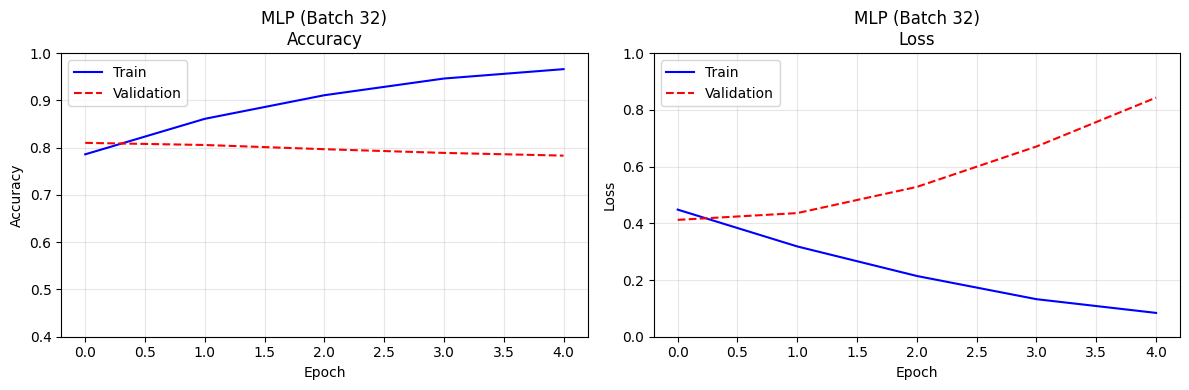

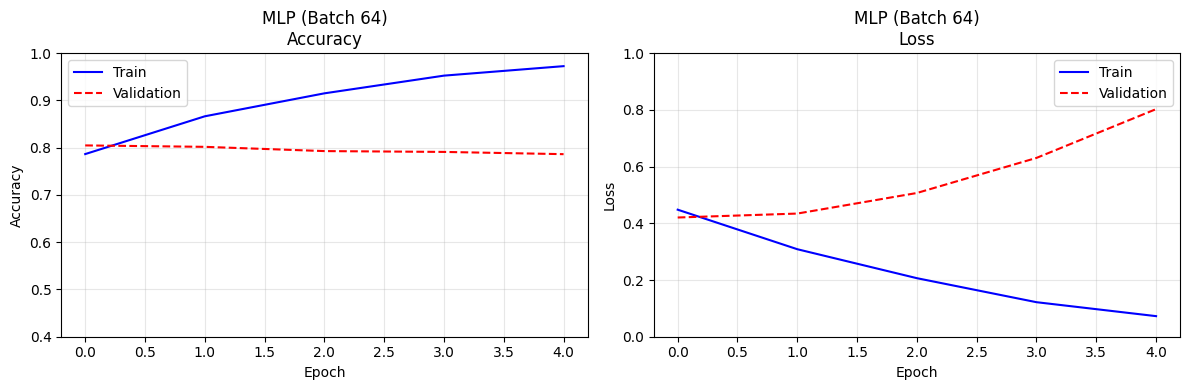

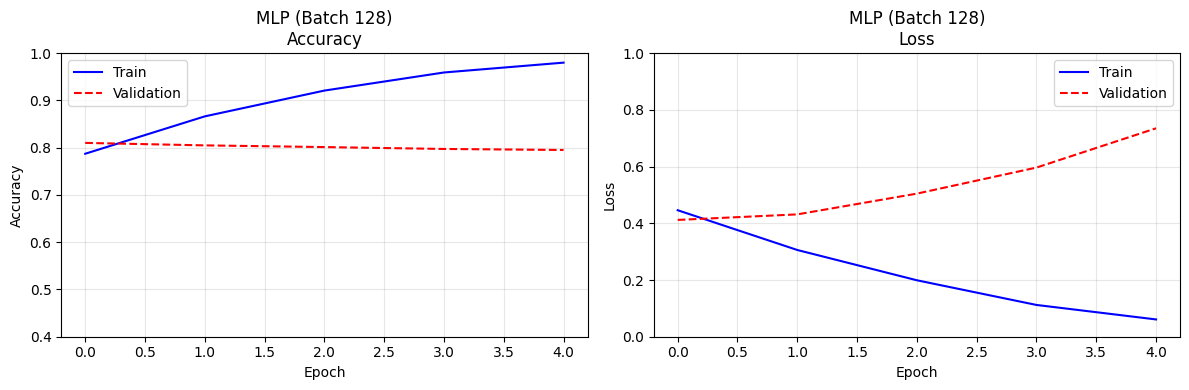

In [44]:
print("Amazon MLP Training Progress:")
for result in mlp_results_amazon:
    plot_model_progress(
        result['history'],
        model_name="MLP",
        batch_size=result['batch_size']
    )

Amazon LSTM Training Progress:


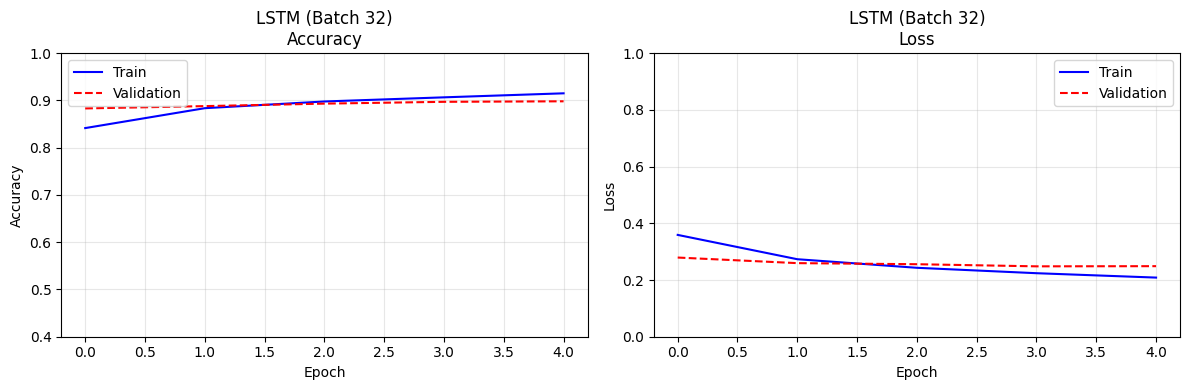

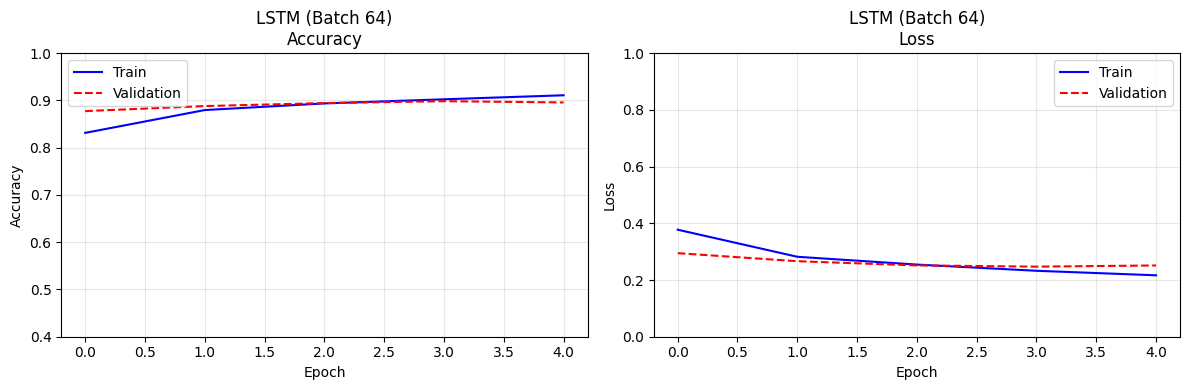

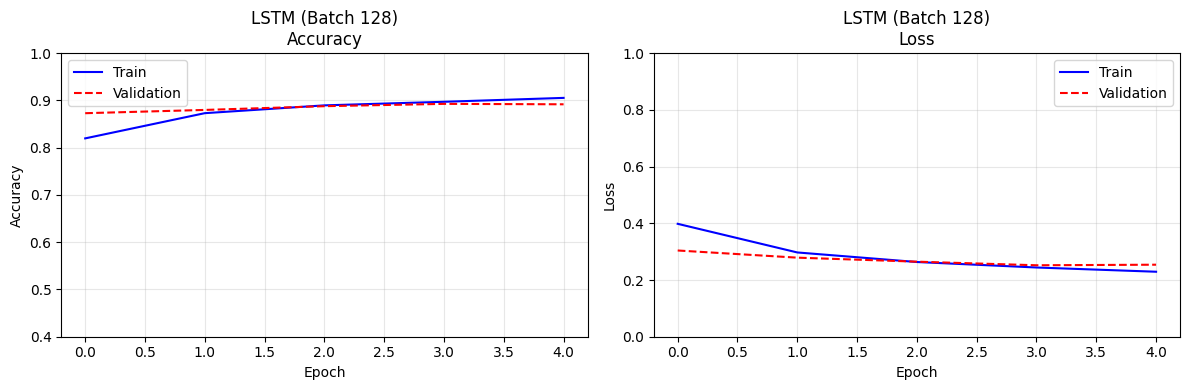

In [45]:
print("Amazon LSTM Training Progress:")
for result in lstm_results_amazon:
    plot_model_progress(
        result['history'],
        model_name="LSTM",
        batch_size=result['batch_size']
    )


MLP Confusion Matrices:
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


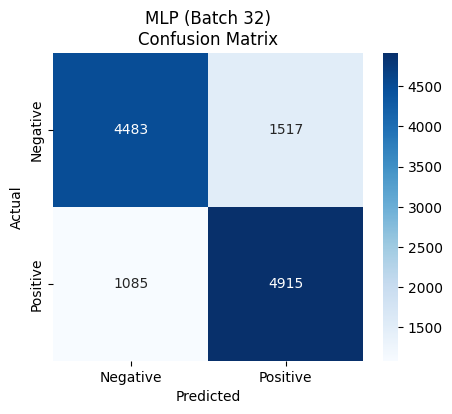


MLP Batch 32 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 4483 |                 1517 |
+-----------------+----------------------+----------------------+
| Actual Positive |                 1085 |                 4915 |
+-----------------+----------------------+----------------------+
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


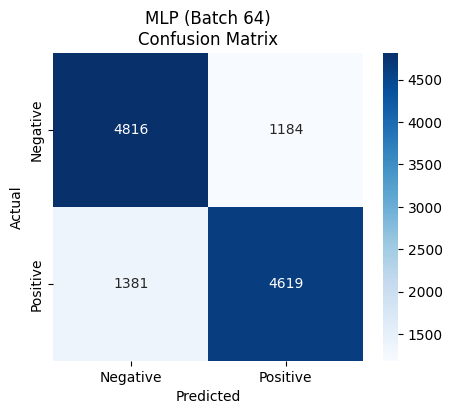


MLP Batch 64 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 4816 |                 1184 |
+-----------------+----------------------+----------------------+
| Actual Positive |                 1381 |                 4619 |
+-----------------+----------------------+----------------------+
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


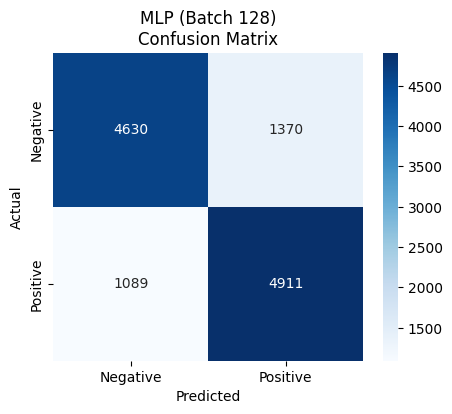


MLP Batch 128 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 4630 |                 1370 |
+-----------------+----------------------+----------------------+
| Actual Positive |                 1089 |                 4911 |
+-----------------+----------------------+----------------------+


In [48]:
print("\nMLP Confusion Matrices:")
for result in mlp_results_amazon:
    y_pred = (result['model'].predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, "MLP", result['batch_size'])

    print(f"\nMLP Batch {result['batch_size']} Confusion Matrix:")
    print(tabulate([[cm[0,0], cm[0,1]], [cm[1,0], cm[1,1]]],
                  headers=['Predicted Negative', 'Predicted Positive'],
                  showindex=['Actual Negative', 'Actual Positive'],
                  tablefmt='grid'))


LSTM Confusion Matrices:
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step


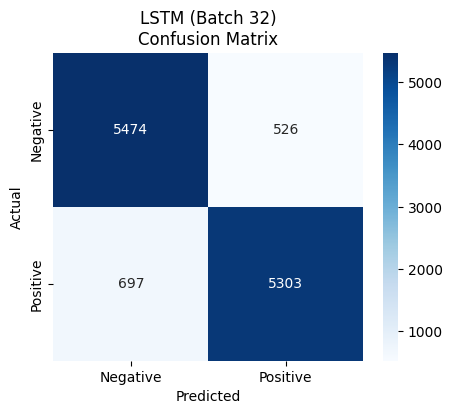


LSTM Batch 32 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 5474 |                  526 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  697 |                 5303 |
+-----------------+----------------------+----------------------+
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step


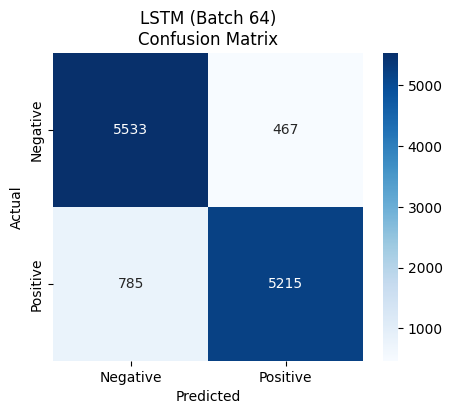


LSTM Batch 64 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 5533 |                  467 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  785 |                 5215 |
+-----------------+----------------------+----------------------+
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step


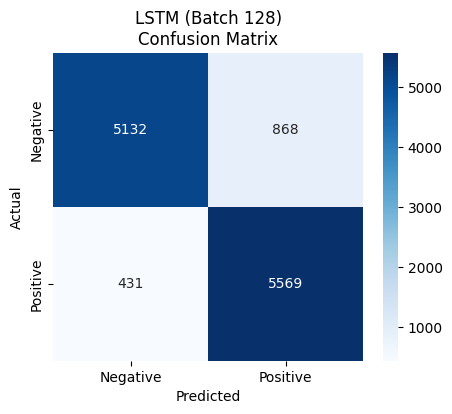


LSTM Batch 128 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 5132 |                  868 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  431 |                 5569 |
+-----------------+----------------------+----------------------+


In [50]:
print("\nLSTM Confusion Matrices:")
for result in lstm_results_amazon:
    y_pred = (result['model'].predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, "LSTM", result['batch_size'])

    print(f"\nLSTM Batch {result['batch_size']} Confusion Matrix:")
    print(tabulate([[cm[0,0], cm[0,1]], [cm[1,0], cm[1,1]]],
                  headers=['Predicted Negative', 'Predicted Positive'],
                  showindex=['Actual Negative', 'Actual Positive'],
                  tablefmt='grid'))